## Kuramoto Sivashinsky

### Numerical Sims

- https://observablehq.com/@rreusser/kuramoto-sivashinsky-equation-in-2d
- https://pydmd.github.io/PyDMD/edmd.html
- https://arxiv.org/pdf/1408.4408
- https://github.com/spectralDNS/shenfun
- https://github.com/graps1/convolutional-edmd/tree/master

#### Implementation 1 (ETDRK4)

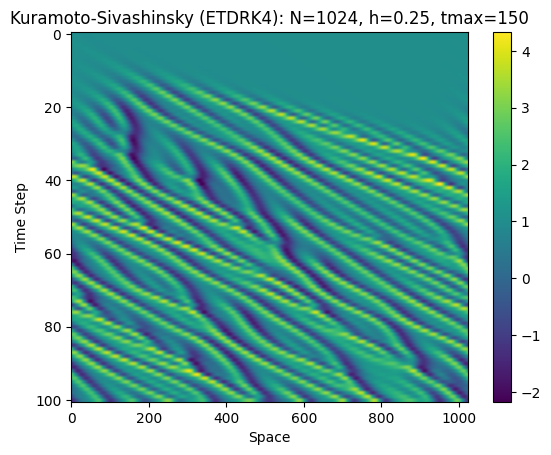

In [13]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

# ============================================
# CONSTANTS AND PARAMETERS
# ============================================
N = 1024          # Number of spatial grid points
h = 0.25          # Time step size
tmax = 150        # Maximum simulation time
M = 16            # Number of points for contour integration (ETDRK4)

# ============================================
# GRID SETUP
# ============================================
# Initial condition and grid setup
x = np.transpose(np.conj(np.arange(1, N+1))) / N  # Normalized domain [0, 1]
a = -1
b = 1
u = np.cos(x/16)*(1+np.sin(x/16))  # Initial condition
v = np.fft.fft(u)

# ============================================
# ETDRK4 SETUP
# ============================================
# Wavenumbers
k = np.transpose(np.conj(np.concatenate((np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0))))) / 16

# Linear operator: L = k^2 - k^4
L = k**2 - k**4

# Exponential integrators
E = np.exp(h*L)      # Full step
E_2 = np.exp(h*L/2)  # Half step

# Contour integration for ETDRK4 coefficients
r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
LR = h*np.transpose(np.repeat([L], M, axis=0)) + np.repeat([r], N, axis=0)
Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))

# ============================================
# TIME INTEGRATION
# ============================================
# Storage arrays
uu = np.array([u])
tt = 0
nmax = round(tmax/h)
nplt = int((tmax/100)/h)  # Save every 1% of simulation
g = -0.5j*k  # Nonlinear term coefficient

# Main time-stepping loop
for n in range(1, nmax+1):
    t = n*h
    Nv = g*np.fft.fft(np.real(np.fft.ifft(v))**2)
    a = E_2*v + Q*Nv
    Na = g*np.fft.fft(np.real(np.fft.ifft(a))**2)
    b = E_2*v + Q*Na
    Nb = g*np.fft.fft(np.real(np.fft.ifft(b))**2)
    c = E_2*a + Q*(2*Nb-Nv)
    Nc = g*np.fft.fft(np.real(np.fft.ifft(c))**2)
    v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
    if n%nplt == 0:
        u = np.real(np.fft.ifft(v))
        uu = np.append(uu, np.array([u]), axis=0)
        tt = np.hstack((tt, t))

# ============================================
# VISUALIZATION
# ============================================
plt.imshow(uu, aspect='auto')
plt.colorbar()
plt.xlabel('Space')
plt.ylabel('Time Step')
plt.title(f'Kuramoto-Sivashinsky (ETDRK4): N={N}, h={h}, tmax={tmax}')
plt.show()

#### Implementation 2 (ETDRK4)

Solution shape: (101, 128), Time shape: (101,)


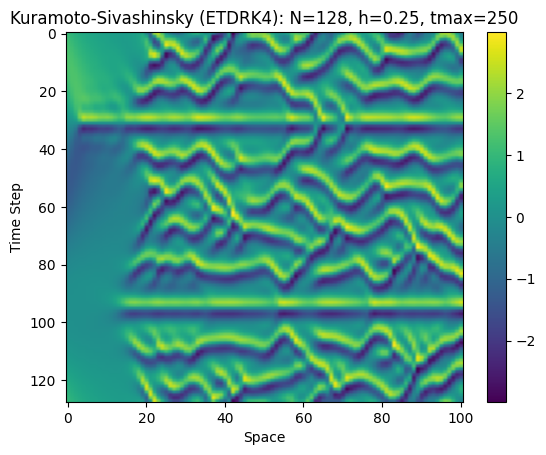

In [14]:
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt

# ============================================
# CONSTANTS AND PARAMETERS
# ============================================
N = 128           # Number of spatial grid points
L_domain = 32*np.pi  # Physical domain length
h = 1/4           # Time step size (0.25)
tmax = 250        # Maximum simulation time
M = 16            # Number of points for contour integration (ETDRK4)

# ============================================
# GRID SETUP
# ============================================
x = L_domain*np.arange(1,N+1)/N  # Physical domain [0, 32π]
u = np.cos(x/16)*(1+np.sin(x/16))  # Initial condition
v = fft(u)

# ============================================
# ETDRK4 SETUP
# ============================================
# Wavenumbers
k = np.concatenate([np.arange(0,N/2),np.array([0.]),np.arange(-N/2+1,0)],0)/16

# Linear operator: L = k^2 - k^4
L = k**2 - k**4

# Exponential integrators
E = np.exp(h*L)   # Full step
E2 = np.exp(h*L/2)  # Half step

# Contour integration for ETDRK4 coefficients
r = np.exp(1j*np.pi*(np.arange(1,M+1)-.5)/M)
LR = np.repeat(h*L[:,None],M,1) + np.repeat(r[None,:],N,0)
Q = h*np.mean(((np.exp(LR/2)-1)/LR),1).real
f1 = h*np.mean(((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3),1).real
f2 = h*np.mean(((2+LR+np.exp(LR)*(-2+LR))/LR**3),1).real
f3 = h*np.mean(((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3),1).real

# ============================================
# TIME INTEGRATION
# ============================================
# Storage lists
uu = [u]
tt = [0]
nmax = int(tmax/h)
nplt = int((tmax/100)/h)  # Save every 1% of simulation
g = -.5j*k  # Nonlinear term coefficient

# Main time-stepping loop
for n in range(1,nmax+1):
    t = n*h
    Nv = g * fft(ifft(v).real**2)
    a = E2*v + Q*Nv
    Na = g * fft(ifft(a).real**2)
    b = E2*v + Q*Na
    Nb = g * fft(ifft(b).real**2)
    c = E2*a + Q*(2*Nb-Nv)
    Nc = g * fft(ifft(c).real**2)
    v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
    if n%nplt==0:
        u = ifft(v).real
        uu.append(u)
        tt.append(t) 

# Convert lists to arrays
uu = np.stack(uu)
tt = np.array(tt)

print(f"Solution shape: {uu.shape}, Time shape: {tt.shape}")

# ============================================
# VISUALIZATION
# ============================================
plt.imshow(uu.T, aspect='auto')
plt.colorbar()
plt.xlabel('Space')
plt.ylabel('Time Step')
plt.title(f'Kuramoto-Sivashinsky (ETDRK4): N={N}, h={h}, tmax={tmax}')
plt.show()

#### Implementation 2a (ETDRK4 - Single Precision float32)

Single Precision (float32)
Solution shape: (101, 128), dtype: float32
Time shape: (101,)
Memory usage: 50.50 KB


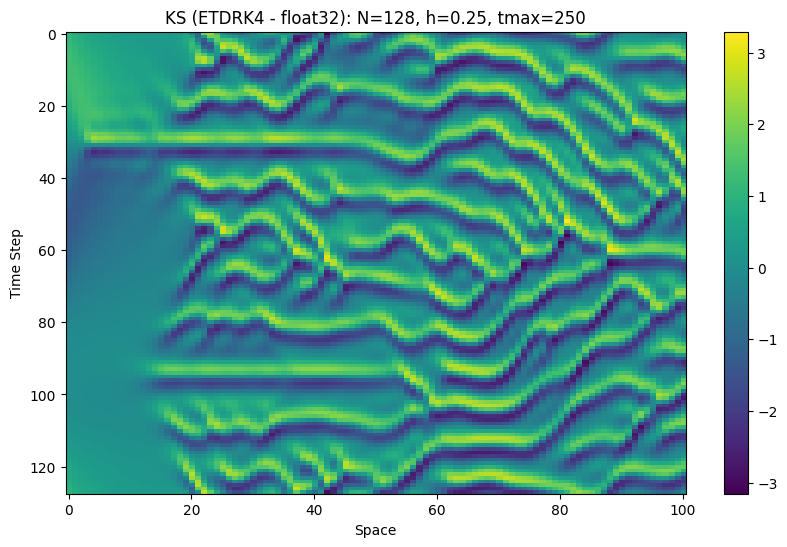

In [15]:
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt

# ============================================
# CONSTANTS AND PARAMETERS
# ============================================
N = 128           # Number of spatial grid points
L_domain = 32*np.pi  # Physical domain length
h = 1/4           # Time step size (0.25)
tmax = 250        # Maximum simulation time
M = 16            # Number of points for contour integration (ETDRK4)
DTYPE = np.float32  # Single precision
DTYPE_COMPLEX = np.complex64  # Complex single precision

# ============================================
# GRID SETUP
# ============================================
x = (L_domain*np.arange(1,N+1)/N).astype(DTYPE)  # Physical domain [0, 32π]
u = (np.cos(x/16)*(1+np.sin(x/16))).astype(DTYPE)  # Initial condition
v = fft(u).astype(DTYPE_COMPLEX)

# ============================================
# ETDRK4 SETUP
# ============================================
# Wavenumbers
k = np.concatenate([np.arange(0,N/2),np.array([0.]),np.arange(-N/2+1,0)],0)/16
k = k.astype(DTYPE)

# Linear operator: L = k^2 - k^4
L = (k**2 - k**4).astype(DTYPE)

# Exponential integrators
E = np.exp(h*L).astype(DTYPE_COMPLEX)   # Full step
E2 = np.exp(h*L/2).astype(DTYPE_COMPLEX)  # Half step

# Contour integration for ETDRK4 coefficients
r = np.exp(1j*np.pi*(np.arange(1,M+1)-.5)/M).astype(DTYPE_COMPLEX)
LR = (np.repeat(h*L[:,None],M,1) + np.repeat(r[None,:],N,0)).astype(DTYPE_COMPLEX)
Q = (h*np.mean(((np.exp(LR/2)-1)/LR),1).real).astype(DTYPE)
f1 = (h*np.mean(((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3),1).real).astype(DTYPE)
f2 = (h*np.mean(((2+LR+np.exp(LR)*(-2+LR))/LR**3),1).real).astype(DTYPE)
f3 = (h*np.mean(((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3),1).real).astype(DTYPE)

# ============================================
# TIME INTEGRATION
# ============================================
# Storage lists
uu_f32 = [u]
tt_f32 = [0]
nmax = int(tmax/h)
nplt = int((tmax/100)/h)  # Save every 1% of simulation
g = (-.5j*k).astype(DTYPE_COMPLEX)  # Nonlinear term coefficient

# Main time-stepping loop
for n in range(1,nmax+1):
    t = n*h
    Nv = (g * fft(ifft(v).real**2)).astype(DTYPE_COMPLEX)
    a = E2*v + Q*Nv
    Na = (g * fft(ifft(a).real**2)).astype(DTYPE_COMPLEX)
    b = E2*v + Q*Na
    Nb = (g * fft(ifft(b).real**2)).astype(DTYPE_COMPLEX)
    c = E2*a + Q*(2*Nb-Nv)
    Nc = (g * fft(ifft(c).real**2)).astype(DTYPE_COMPLEX)
    v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
    if n%nplt==0:
        u = ifft(v).real.astype(DTYPE)
        uu_f32.append(u)
        tt_f32.append(t) 

# Convert lists to arrays
uu_f32 = np.stack(uu_f32)
tt_f32 = np.array(tt_f32)

print(f"Single Precision (float32)")
print(f"Solution shape: {uu_f32.shape}, dtype: {uu_f32.dtype}")
print(f"Time shape: {tt_f32.shape}")
print(f"Memory usage: {uu_f32.nbytes / 1024:.2f} KB")

# ============================================
# VISUALIZATION
# ============================================
plt.figure(figsize=(10, 6))
plt.imshow(uu_f32.T, aspect='auto')
plt.colorbar()
plt.xlabel('Space')
plt.ylabel('Time Step')
plt.title(f'KS (ETDRK4 - float32): N={N}, h={h}, tmax={tmax}')
plt.show()

#### Implementation 2b (ETDRK4 - Double Precision float64)

Double Precision (float64)
Solution shape: (101, 128), dtype: float64
Time shape: (101,)
Memory usage: 101.00 KB


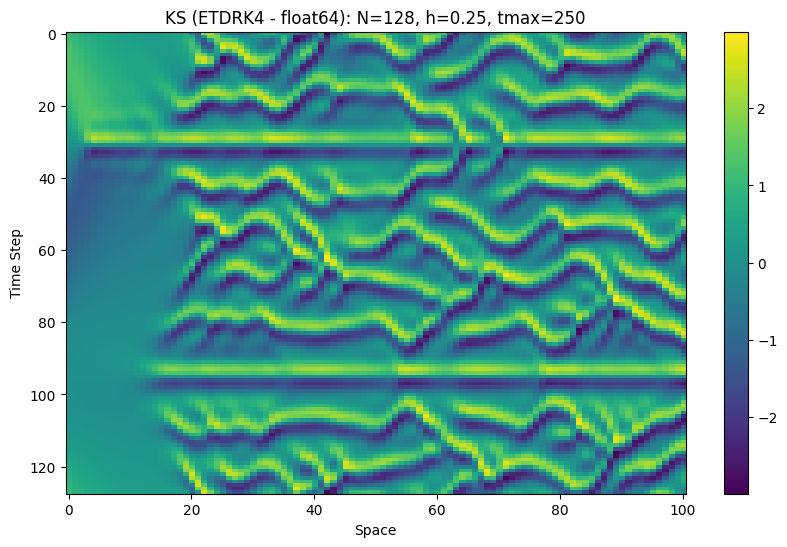

In [16]:
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt

# ============================================
# CONSTANTS AND PARAMETERS
# ============================================
N = 128           # Number of spatial grid points
L_domain = 32*np.pi  # Physical domain length
h = 1/4           # Time step size (0.25)
tmax = 250        # Maximum simulation time
M = 16            # Number of points for contour integration (ETDRK4)
DTYPE = np.float64  # Double precision (default)
DTYPE_COMPLEX = np.complex128  # Complex double precision

# ============================================
# GRID SETUP
# ============================================
x = (L_domain*np.arange(1,N+1)/N).astype(DTYPE)  # Physical domain [0, 32π]
u = (np.cos(x/16)*(1+np.sin(x/16))).astype(DTYPE)  # Initial condition
v = fft(u).astype(DTYPE_COMPLEX)

# ============================================
# ETDRK4 SETUP
# ============================================
# Wavenumbers
k = np.concatenate([np.arange(0,N/2),np.array([0.]),np.arange(-N/2+1,0)],0)/16
k = k.astype(DTYPE)

# Linear operator: L = k^2 - k^4
L = (k**2 - k**4).astype(DTYPE)

# Exponential integrators
E = np.exp(h*L).astype(DTYPE_COMPLEX)   # Full step
E2 = np.exp(h*L/2).astype(DTYPE_COMPLEX)  # Half step

# Contour integration for ETDRK4 coefficients
r = np.exp(1j*np.pi*(np.arange(1,M+1)-.5)/M).astype(DTYPE_COMPLEX)
LR = (np.repeat(h*L[:,None],M,1) + np.repeat(r[None,:],N,0)).astype(DTYPE_COMPLEX)
Q = (h*np.mean(((np.exp(LR/2)-1)/LR),1).real).astype(DTYPE)
f1 = (h*np.mean(((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3),1).real).astype(DTYPE)
f2 = (h*np.mean(((2+LR+np.exp(LR)*(-2+LR))/LR**3),1).real).astype(DTYPE)
f3 = (h*np.mean(((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3),1).real).astype(DTYPE)

# ============================================
# TIME INTEGRATION
# ============================================
# Storage lists
uu_f64 = [u]
tt_f64 = [0]
nmax = int(tmax/h)
nplt = int((tmax/100)/h)  # Save every 1% of simulation
g = (-.5j*k).astype(DTYPE_COMPLEX)  # Nonlinear term coefficient

# Main time-stepping loop
for n in range(1,nmax+1):
    t = n*h
    Nv = (g * fft(ifft(v).real**2)).astype(DTYPE_COMPLEX)
    a = E2*v + Q*Nv
    Na = (g * fft(ifft(a).real**2)).astype(DTYPE_COMPLEX)
    b = E2*v + Q*Na
    Nb = (g * fft(ifft(b).real**2)).astype(DTYPE_COMPLEX)
    c = E2*a + Q*(2*Nb-Nv)
    Nc = (g * fft(ifft(c).real**2)).astype(DTYPE_COMPLEX)
    v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
    if n%nplt==0:
        u = ifft(v).real.astype(DTYPE)
        uu_f64.append(u)
        tt_f64.append(t) 

# Convert lists to arrays
uu_f64 = np.stack(uu_f64)
tt_f64 = np.array(tt_f64)

print(f"Double Precision (float64)")
print(f"Solution shape: {uu_f64.shape}, dtype: {uu_f64.dtype}")
print(f"Time shape: {tt_f64.shape}")
print(f"Memory usage: {uu_f64.nbytes / 1024:.2f} KB")

# ============================================
# VISUALIZATION
# ============================================
plt.figure(figsize=(10, 6))
plt.imshow(uu_f64.T, aspect='auto')
plt.colorbar()
plt.xlabel('Space')
plt.ylabel('Time Step')
plt.title(f'KS (ETDRK4 - float64): N={N}, h={h}, tmax={tmax}')
plt.show()

#### Comparison: float32 vs float64

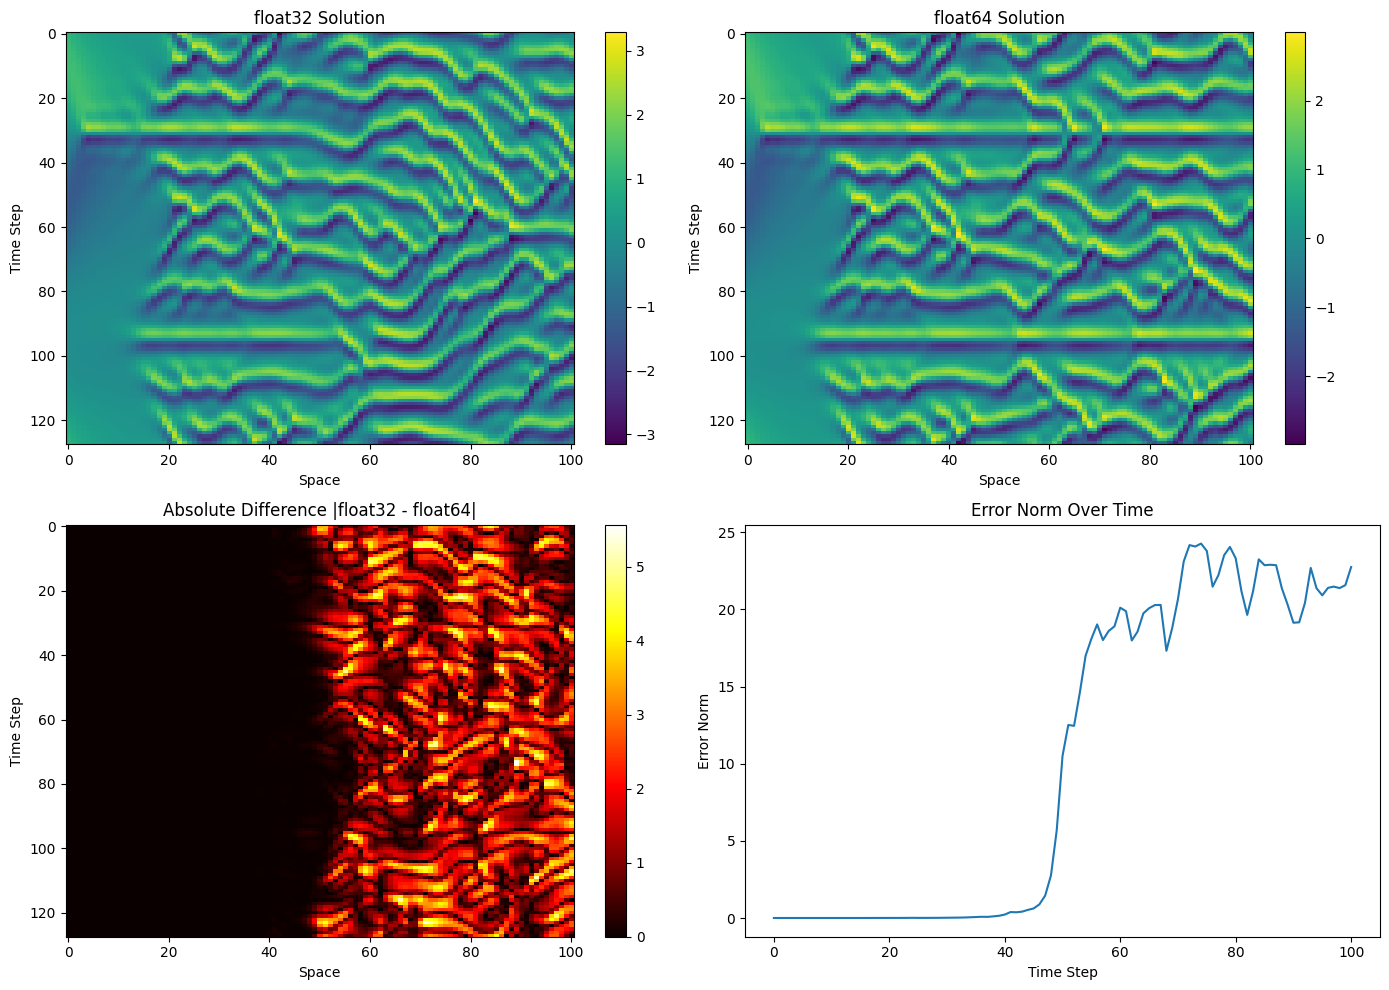


PRECISION COMPARISON STATISTICS
Max absolute difference: 5.57e+00
Mean absolute difference: 7.33e-01
Max relative error: 3.01e+09
Mean relative error: 1.55e+06

Memory usage:
  float32: 50.50 KB
  float64: 101.00 KB
  Ratio: 2.0x


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Compare the solutions
difference = np.abs(uu_f32 - uu_f64)
relative_error = difference / (np.abs(uu_f64) + 1e-10)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot float32
im1 = axes[0, 0].imshow(uu_f32.T, aspect='auto', cmap='viridis')
axes[0, 0].set_title('float32 Solution')
axes[0, 0].set_xlabel('Space')
axes[0, 0].set_ylabel('Time Step')
plt.colorbar(im1, ax=axes[0, 0])

# Plot float64
im2 = axes[0, 1].imshow(uu_f64.T, aspect='auto', cmap='viridis')
axes[0, 1].set_title('float64 Solution')
axes[0, 1].set_xlabel('Space')
axes[0, 1].set_ylabel('Time Step')
plt.colorbar(im2, ax=axes[0, 1])

# Plot absolute difference
im3 = axes[1, 0].imshow(difference.T, aspect='auto', cmap='hot')
axes[1, 0].set_title('Absolute Difference |float32 - float64|')
axes[1, 0].set_xlabel('Space')
axes[1, 0].set_ylabel('Time Step')
plt.colorbar(im3, ax=axes[1, 0])

# Plot error
axes[1, 1].plot(np.linalg.norm((uu_f32 - uu_f64), axis=1))
axes[1, 1].set_title('Error Norm Over Time')
axes[1, 1].set_xlabel('Time Step')
axes[1, 1].set_ylabel('Error Norm')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*50}")
print(f"PRECISION COMPARISON STATISTICS")
print(f"{'='*50}")
print(f"Max absolute difference: {np.max(difference):.2e}")
print(f"Mean absolute difference: {np.mean(difference):.2e}")
print(f"Max relative error: {np.max(relative_error):.2e}")
print(f"Mean relative error: {np.mean(relative_error):.2e}")
print(f"\nMemory usage:")
print(f"  float32: {uu_f32.nbytes / 1024:.2f} KB")
print(f"  float64: {uu_f64.nbytes / 1024:.2f} KB")
print(f"  Ratio: {uu_f64.nbytes / uu_f32.nbytes:.1f}x")
print(f"{'='*50}")

#### Implementation 3 (CN-AB2)

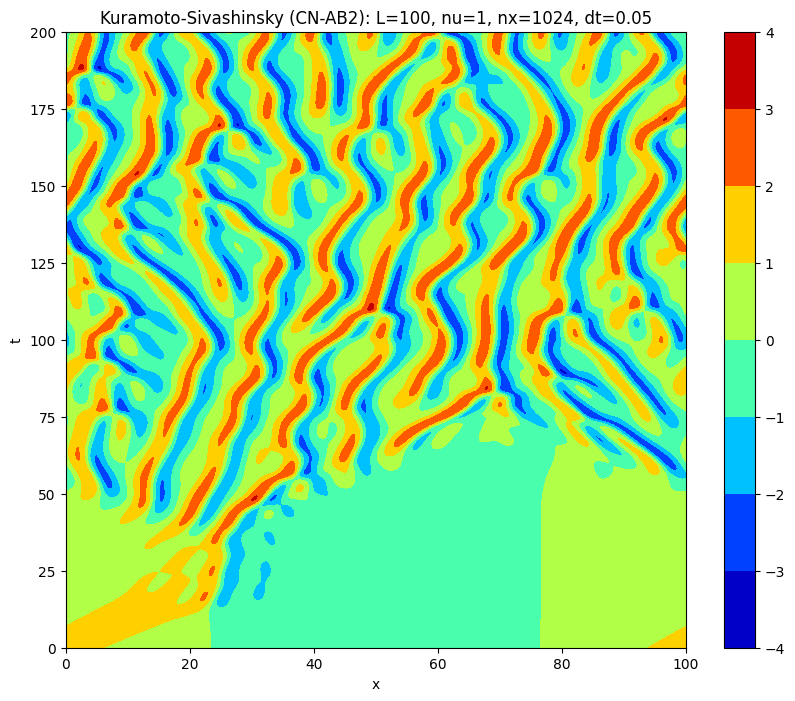

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# ============================================
# CONSTANTS AND PARAMETERS
# ============================================
nu = 1            # Diffusion coefficient
L = 100           # Physical domain length
nx = 1024         # Number of spatial grid points
t0 = 0            # Initial time
tN = 200          # Final time
dt = 0.05         # Time step size

# ============================================
# DERIVED PARAMETERS
# ============================================
nt = int((tN - t0) / dt)  # Number of time steps

# ============================================
# GRID SETUP
# ============================================
# Wave number mesh
k = np.arange(-nx/2, nx/2, 1)

# Physical grids
t = np.linspace(start=t0, stop=tN, num=nt)
x = np.linspace(start=0, stop=L, num=nx)

# Solution meshes
u = np.ones((nx, nt))              # Real space
u_hat = np.ones((nx, nt), dtype=complex)   # Fourier space
u_hat2 = np.ones((nx, nt), dtype=complex)  # Fourier space (u^2)

# ============================================
# INITIAL CONDITION
# ============================================
u0 = np.cos((2 * np.pi * x) / L) + 0.1 * np.cos((4 * np.pi * x) / L)

# Fourier transforms of initial condition
u0_hat = (1 / nx) * np.fft.fftshift(np.fft.fft(u0))
u0_hat2 = (1 / nx) * np.fft.fftshift(np.fft.fft(u0**2))

# Set initial conditions
u[:,0] = u0
u_hat[:,0] = u0_hat
u_hat2[:,0] = u0_hat2

# ============================================
# OPERATORS (Crank-Nicolson + Adams-Bashforth)
# ============================================
# Fourier Transform of the linear operator: L = k^2 - nu*k^4
FL = (((2 * np.pi) / L) * k) ** 2 - nu * (((2 * np.pi) / L) * k) ** 4

# Fourier Transform of the non-linear operator: N = -1/2 * i*k
FN = - (1 / 2) * ((1j) * ((2 * np.pi) / L) * k)

# ============================================
# TIME INTEGRATION (CN-AB2)
# ============================================
for j in range(0,nt-1):
  uhat_current = u_hat[:,j]
  uhat_current2 = u_hat2[:,j]
  
  # Get previous timestep (for Adams-Bashforth)
  if j == 0:
    uhat_last = u_hat[:,0]
    uhat_last2 = u_hat2[:,0]
  else:
    uhat_last = u_hat[:,j-1]
    uhat_last2 = u_hat2[:,j-1]
  
  # Crank-Nicolson (implicit linear) + Adams-Bashforth 2 (explicit nonlinear)
  u_hat[:,j+1] = (1 / (1 - (dt / 2) * FL)) * ( (1 + (dt / 2) * FL) * uhat_current + ( ((3 / 2) * FN) * (uhat_current2) - ((1 / 2) * FN) * (uhat_last2) ) * dt )
  
  # Transform back to real space
  u[:,j+1] = np.real(nx * np.fft.ifft(np.fft.ifftshift(u_hat[:,j+1])))
  
  # Update nonlinear term in Fourier space
  u_hat2[:,j+1] = (1 / nx) * np.fft.fftshift(np.fft.fft(u[:,j+1]**2))

# ============================================
# VISUALIZATION
# ============================================
fig, ax = plt.subplots(figsize=(10,8))

xx, tt = np.meshgrid(x, t)
levels = np.arange(-3, 3, 0.01)
cs = ax.contourf(xx, tt, u.T, cmap=cm.jet)
fig.colorbar(cs)

ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title(f"Kuramoto-Sivashinsky (CN-AB2): L={L}, nu={nu}, nx={nx}, dt={dt}")
plt.show()

### DMD fitting

#### Vanilla

DMD time: {'t0': 0, 'tend': 19, 'dt': 1}


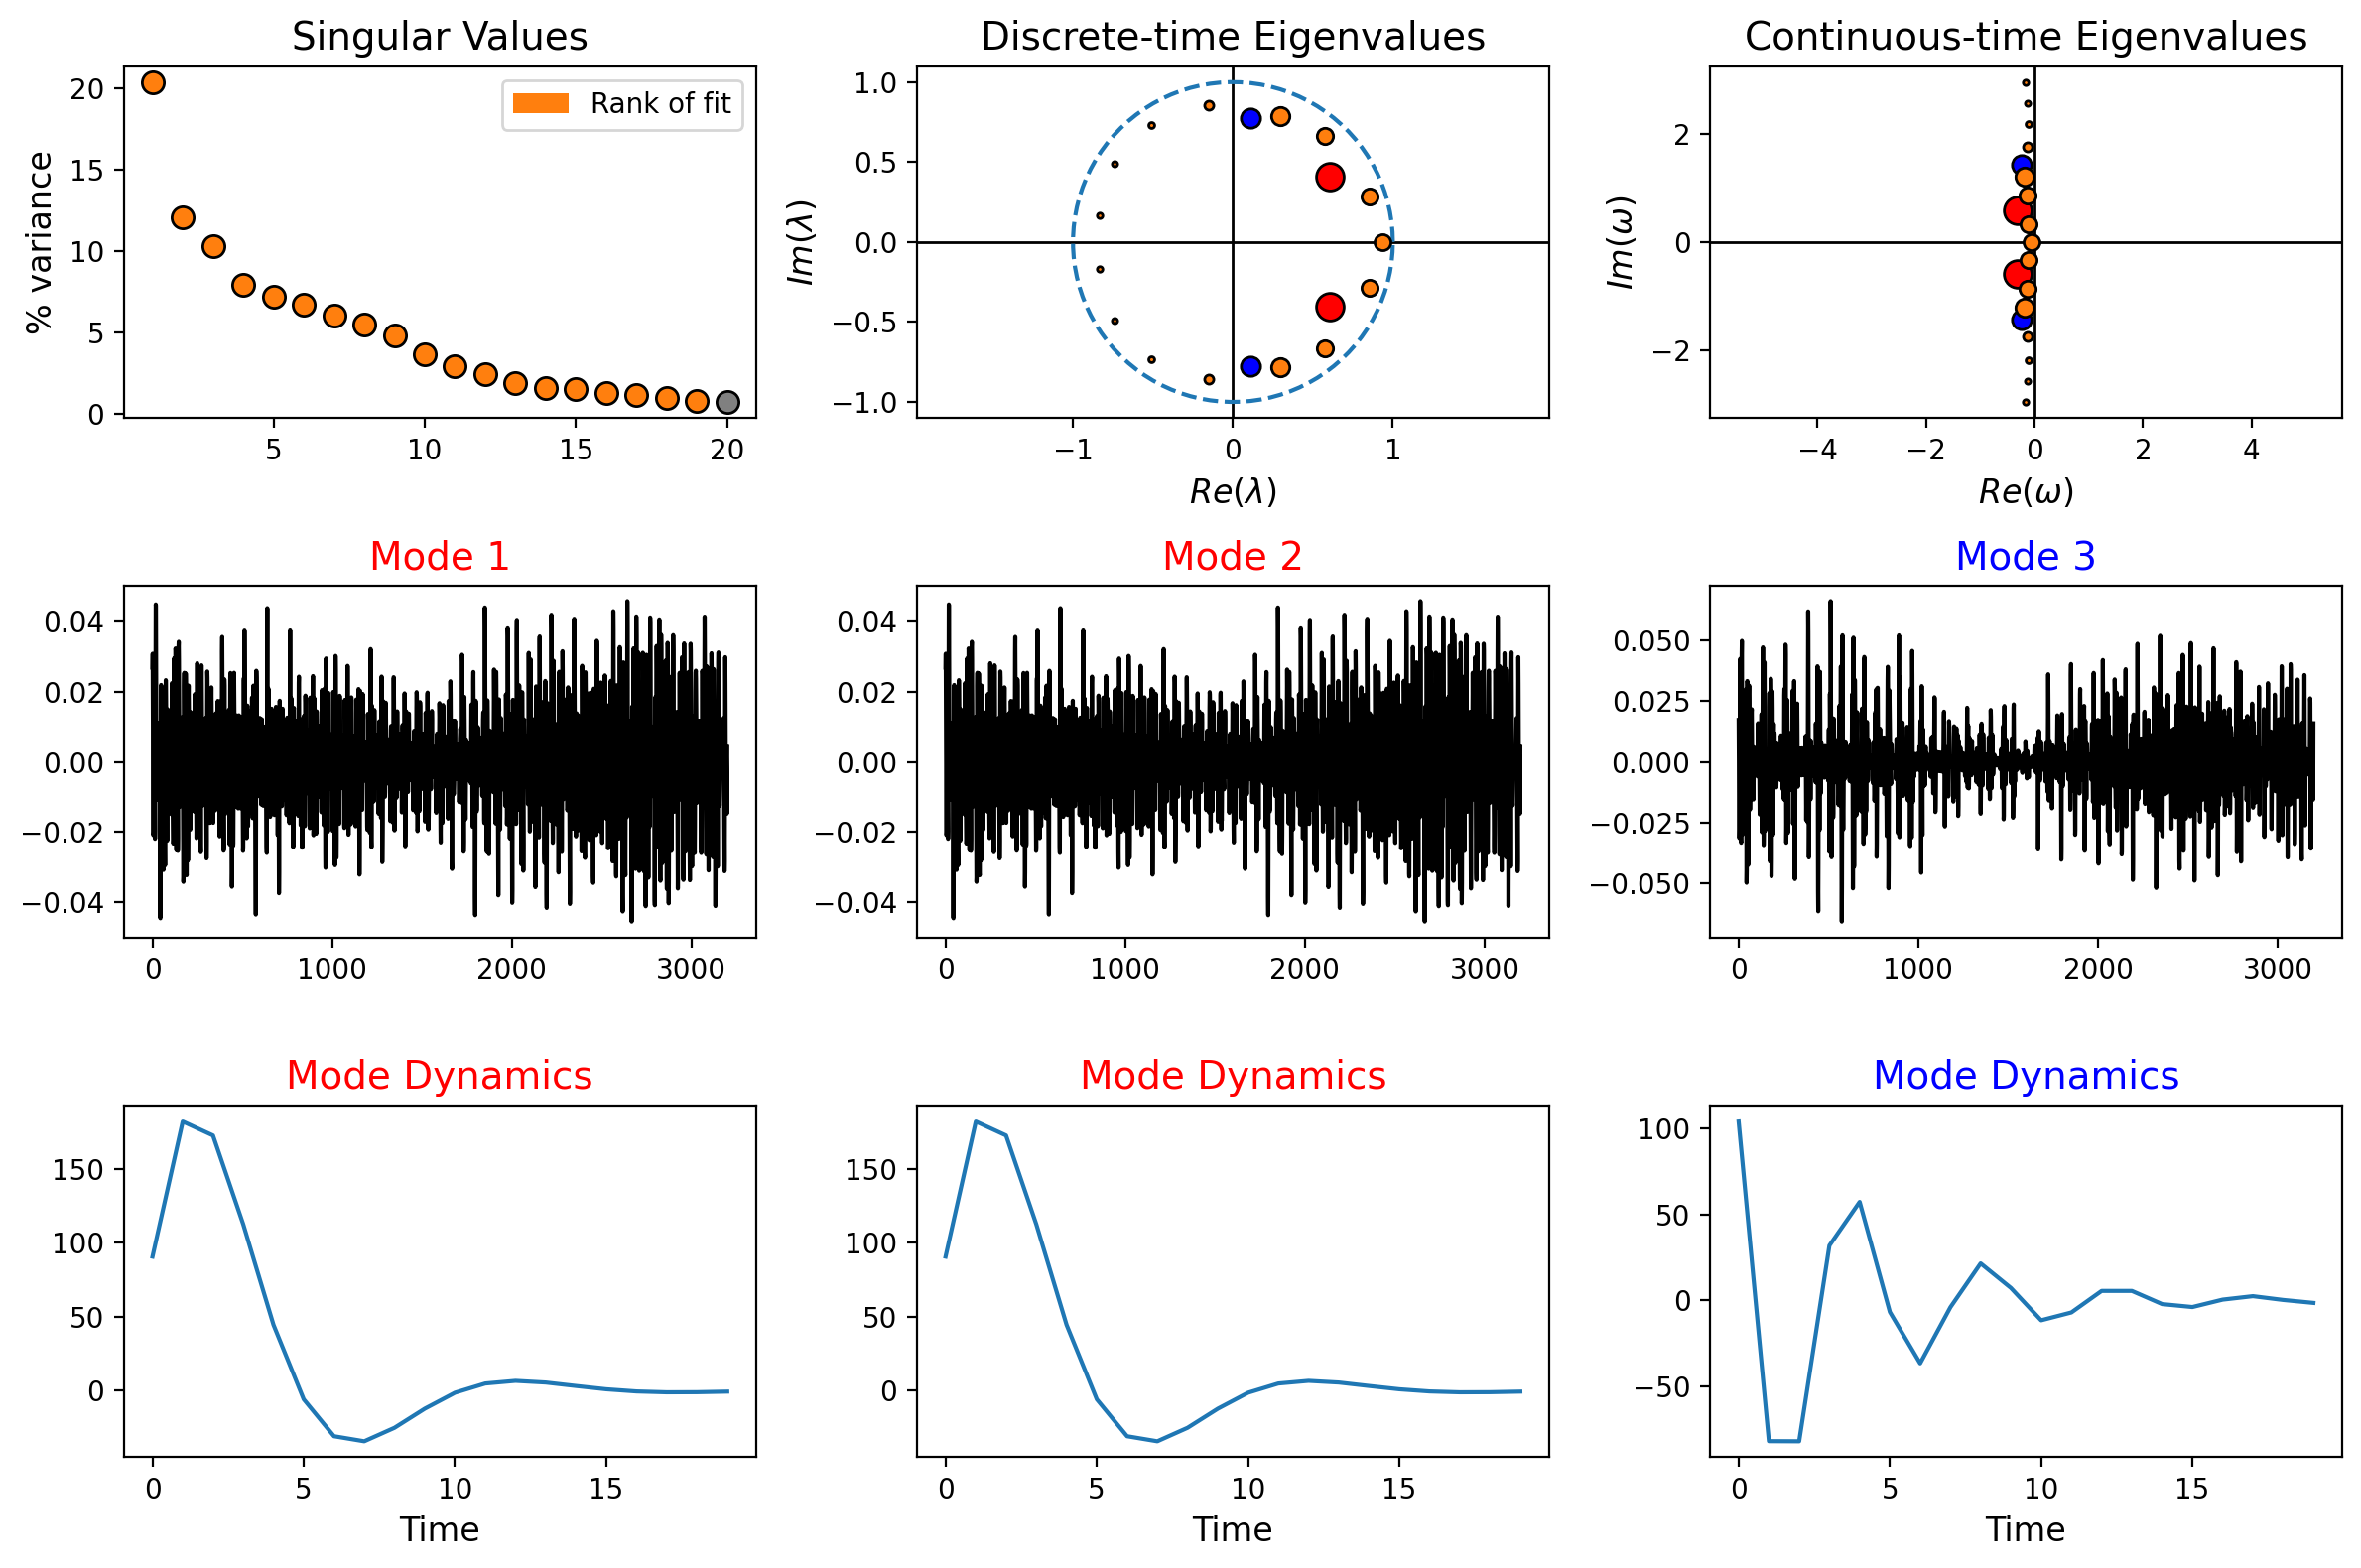

Frequencies (imaginary component): [-0.06511092+0.j         -0.10211617+0.32442475j -0.10211617-0.32442475j
 -0.13148556+0.8597801j  -0.13148556-0.8597801j  -0.31477485+0.58960339j
 -0.31477485-0.58960339j -0.17531975+1.20769021j -0.17531975-1.20769021j
 -0.24514705+1.42804324j -0.24514705-1.42804324j -0.13833138+1.74467753j
 -0.13833138-1.74467753j -0.11309163+2.17955208j -0.11309163-2.17955208j
 -0.1203821 +2.55390262j -0.1203821 -2.55390262j -0.16240569+2.94568768j
 -0.16240569-2.94568768j]


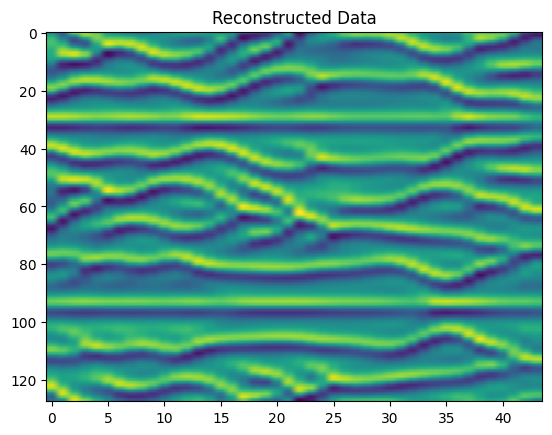

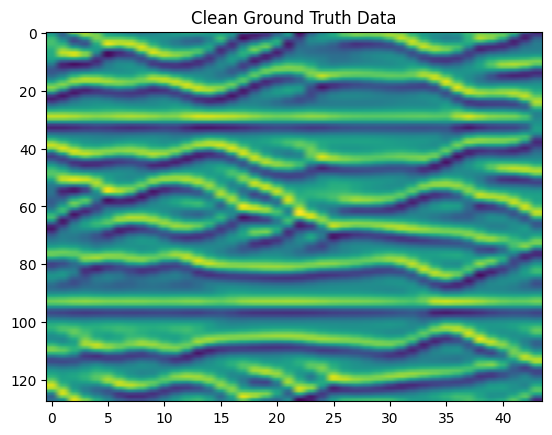

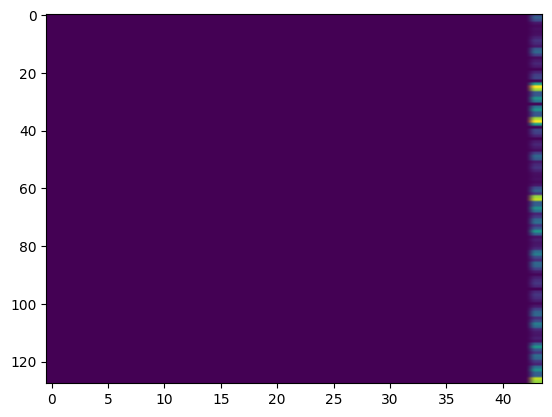

In [19]:
from pydmd import DMD
from pydmd.plotter import plot_summary
from pydmd.preprocessing import hankel_preprocessing

training_snapshots = uu_f64.T[..., 20:len(uu_f64.T-20)//2]

# 50, 100
d = 25  # we will use this number of delays throughout the tutorial
dmd_basic = DMD(svd_rank=20)
dmd = hankel_preprocessing(dmd_basic, d=d)
dmd.fit(training_snapshots)

print(f"DMD time: {dmd.dmd_time}")

plot_summary(dmd, max_sval_plot=1000)

print(
    f"Frequencies (imaginary component): {np.round(np.log(dmd.eigs) / 1, decimals=12)}"
)
plt.title("Reconstructed Data")
plt.imshow(dmd.reconstructed_data.real, aspect='auto')
plt.show()
plt.title("Clean Ground Truth Data")
plt.imshow(training_snapshots, aspect='auto')
plt.show()
plt.imshow(np.abs(training_snapshots - dmd.reconstructed_data.real), aspect='auto')

Extended DMD time: {'t0': 0, 'tend': 76, 'dt': 1}


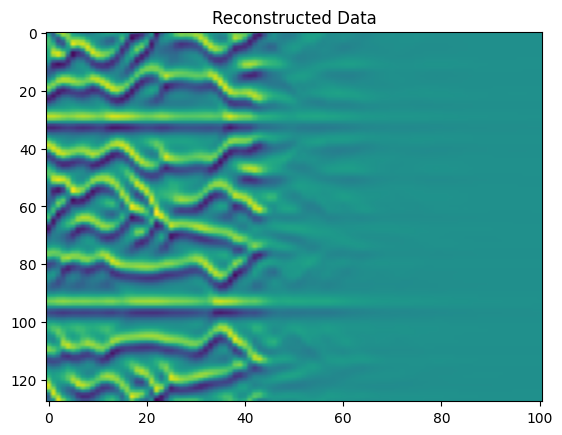

In [20]:
### Extend tend

dmd.dmd_time['tend'] *= 4
print(f"Extended DMD time: {dmd.dmd_time}")

plt.title("Reconstructed Data")
plt.imshow(dmd.reconstructed_data.real, aspect='auto')
plt.show()

#### Extended

In [21]:
def plot_lorenz_reconstruction(true_data, recon_data, recon_title, recon_color):
    """
    Helper function that plots the provided true Lorenz trajectory side-by-side
    with the provided reconstructed trajectory. Uses the provided plotting
    parameters for the reconstruction subplot.
    """
    fig = plt.figure(figsize=(6, 3))
    # Plot the true trajectory in black.
    ax = fig.add_subplot(121, projection="3d")
    ax.plot(true_data[0], true_data[1], true_data[2], c="k")
    ax.set_title("True system")
    # ax.set_xlim([-29, 29])
    # ax.set_ylim([-29, 29])
    # ax.set_zlim([5, 45])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    # Plot the reconstructed trajectory in the given color.
    ax = fig.add_subplot(122, projection="3d")
    ax.plot(recon_data[0], recon_data[1], recon_data[2], c=recon_color)
    ax.set_title(recon_title)
    # ax.set_xlim([-29, 29])
    # ax.set_ylim([-29, 29])
    # ax.set_zlim([5, 45])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    plt.tight_layout()
    plt.show()

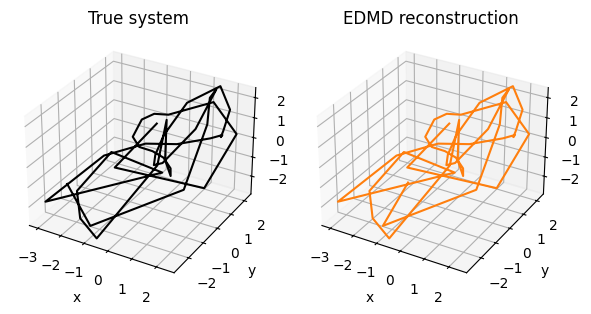

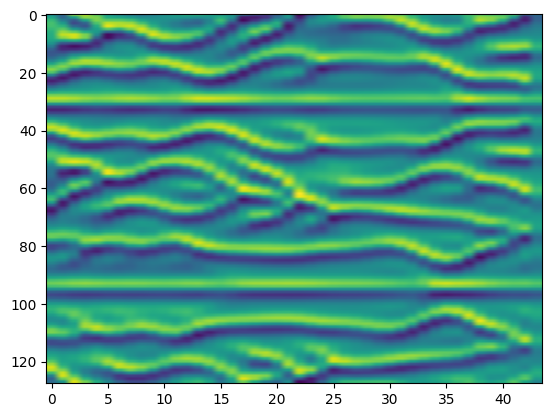

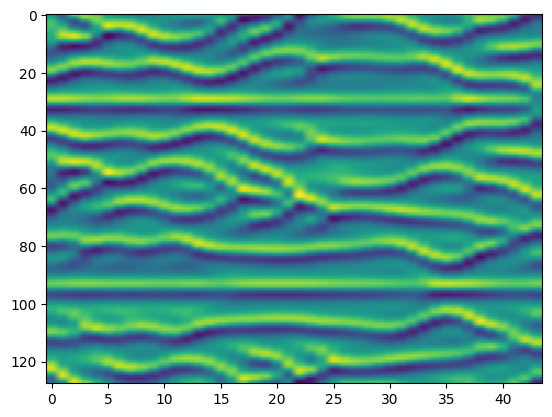

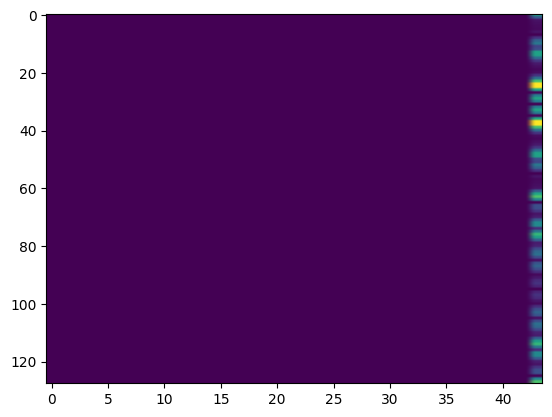

In [30]:
from pydmd import EDMD
#Note: This cell may take a while to run (approximately 10 minutes).

edmd = EDMD(
    svd_rank=100,
    kernel_metric="laplacian",
)
edmd.fit(training_snapshots)

edmd_recon = edmd.reconstructed_data.real
plot_lorenz_reconstruction(training_snapshots, edmd_recon, "EDMD reconstruction", "tab:orange")

plt.imshow(edmd_recon.real, aspect='auto')
plt.show()
plt.imshow(training_snapshots, aspect='auto')
plt.show()
plt.imshow(np.abs(training_snapshots - edmd_recon.real), aspect='auto')

Extended DMD time: {'t0': 0, 'tend': 64.5, 'dt': 1}


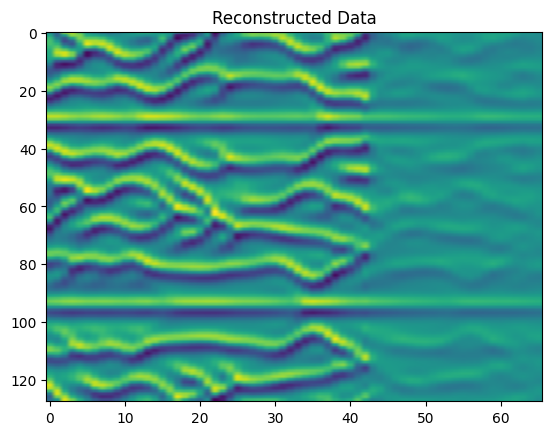

In [31]:
### Extend tend

edmd.dmd_time['tend'] *= 1.5
print(f"Extended DMD time: {edmd.dmd_time}")

plt.title("Reconstructed Data")
plt.imshow(edmd.reconstructed_data.real, aspect='auto')